<a href="https://colab.research.google.com/github/Mariana-zy/SyS-2025-2S/blob/main/Taller2/Punto_1_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Punto 1.7**

**Ejercicio 1. Aplicación en circuitos eléctricos - potencia:** Consulte en
qué consiste la distorsión total de armónicos (Total Harmonic
Distortion-(THD)) y el factor de potencia en un circuito
eléctrico. Cómo puede calcularse el THD desde la FFT?.
Cómo puede calcularse la distorsión del factor de potencia
con base al THD?.

# ¿Qué es el THD?

La Distorsión Total de Armónicos (Total Harmonic Distortion, THD) mide la proporción de energía presente en las componentes armónicas (segundo, tercero, ...) respecto a la componente fundamental de una señal periódica.  
Si $V_n$ es el valor RMS (o magnitud eficaz) del $n$-ésimo armónico y $V_1$ el RMS del armónico fundamental, el THD se define como:

$$
\text{THD} \;=\; \frac{\sqrt{V_2^2 + V_3^2 + \dots + V_N^2}}{V_1}
$$

A veces se expresa en porcentaje: $\text{THD}\% = 100 \cdot \text{THD}$.

# Factor de potencia (PF) en un circuito eléctrico

Mide qué tan eficientemente un circuito usa la energía eléctrica. Indica la proporción entre la potencia útil (activa) y la potencia total suministrada.

* **En circuitos senoidales puros:** Si la corriente y el voltaje son senoidales, el factor de potencia se calcula como:

  $ PF = \cos(\varphi) $

  donde $ \varphi $ es el ángulo de desfase entre el voltaje y la corriente.

  Si $ \varphi = 0 $, entonces $ PF = 1 $ (máxima eficiencia).

  Si $ \varphi > 0 $, aparece energía reactiva y $ PF < 1 $.

* **En circuitos no senoidales (con distorsión):** Cuando la señal tiene armónicos, el factor de potencia también disminuye aunque no haya desfase. En este caso se usa el factor de potencia total basado en la distorsión armónica total (THD):

  $ THD = \frac{\sqrt{V_2^2 + V_3^2 + \cdots + V_n^2}}{V_1} $
  
  $ PF_{THD} = \frac{1}{\sqrt{1 + (THD)^2}} $

  donde $ V_1 $ es la componente fundamental y $ V_2, V_3, ... $ son los armónicos.

# ¿Cómo se calcula el THD desde la FFT?

1. Calcular la FFT (o rFFT para señales reales) de la señal periódica muestreada.  
2. Obtener el espectro single-sided (solo el espectro positivo) y normalizarlo (dividir por número de muestras).  
3. Identificar el bin (pequeño intervalo de frecuencia donde se concentra parte de la energía del espectro) correspondiente a la frecuencia fundamental $f_1$ y sus múltiplos (armónicos).  
4. Obtener $V_n$ como la magnitud (amplitud eficaz) de cada armónico (convertir amplitud de pico a RMS si es necesario).  
5. Aplicar la fórmula del THD.

**Filtro práctico para identificar armónicos**: Se buscan picos en las frecuencias próximas a $k f_1$, $k=1,2,\dots$.

# ¿Cómo puede calcularse la distorsión del factor de potencia con base al THD?

Si una señal posee armónicos, la componente armónica reduce la potencia útil asociada a la fundamental. Una aproximación simple que relaciona THD con la pérdida de factor de potencia por distorsión es:

$$ \text{PF}_{\text{THD}} \approx \frac{1}{\sqrt{1 + \text{THD}^2}} $$

Esta expresión supone que el desfase de la componente fundamental es nulo (o despreciable) y que el efecto principal es la presencia de armónicos.

**Ejercicio 2:** Genere un ejemplo ilustrativo para el cálculo del THD y la distorsión del factor de potencia para un rectificador de onda completa con carga:
1. Netamente resistiva.
2. Carga RC en serie.

Establezca las condiciones necesarias para las simulaciones y pruebe con diferentes valores
de R y C. Discuta los resultados obtenidos.

In [ ]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import scipy.signal as sig

# 1. Definición del sistema RC
s = sym.symbols('s', complex=True)
R, C = sym.symbols('R C', positive=True)
X = sym.Function('X')(s)

# Función de transferencia circuito RC serie
Y = 1 / (R*C*s + 1) * X

# 2. Parámetros de simulación
Fo = 60        # frecuencia de alimentación [Hz]
Fs = 30*Fo     # frecuencia de muestreo [Hz]
To = 1/Fo
Ts = 1/Fs
t = np.arange(0, 5*To, Ts)  # 5 periodos simulados
A = 120        # amplitud de la fuente

# 3. Entrada: señal senoidal rectificada completa
in_o = A*np.sin(2*np.pi*Fo*t)           # señal senoidal
rec_c = sig.square(2*np.pi*Fo*t)        # tren de pulsos
in_r = in_o * rec_c                     # señal rectificada (onda completa)

# 4. Función de transferencia para distintos casos
def salida_rectificador(R_v, C_v=None):
    if C_v is None:  # solo resistencia
        num = np.array([1])
        den = np.array([1])
    else:            # carga RC serie
        num = np.array([1])
        den = np.array([R_v*C_v, 1])
    G_n = sig.TransferFunction(num, den)
    out = G_n.output(in_r, T=t)[1]
    return out

# 5. Calcular FFT, THD y PF
def calc_THD_PF(signal, Fs):
    N = len(signal)
    freqs = np.fft.rfftfreq(N, 1/Fs)
    spectrum = np.abs(np.fft.rfft(signal))/N

    # localizar la frecuencia fundamental (pico más alto)
    fundamental_bin = np.argmax(spectrum)
    V1 = spectrum[fundamental_bin]
    harmonics = np.delete(spectrum, fundamental_bin)
    THD = np.sqrt(np.sum(harmonics**2)) / V1
    PF_THD = 1 / np.sqrt(1 + THD**2)
    return THD, PF_THD, freqs, spectrum

# 6. Caso 1) Carga resistiva
R_v = 1000
out_R = salida_rectificador(R_v)
THD_R, PF_R, fR, specR = calc_THD_PF(out_R, Fs)

# 7. Caso 2) carga RC
R_v = 1000
C_v = 10e-6
out_RC = salida_rectificador(R_v, C_v)
THD_RC, PF_RC, fRC, specRC = calc_THD_PF(out_RC, Fs)

# 8. Resultados
print("Carga resistiva")
print(f"THD = {THD_R:.4f} ({THD_R*100:.2f}%)")
print(f"Factor de potencia (por THD): {PF_R:.4f}\n")

print("Carga RC")
print(f"THD = {THD_RC:.4f} ({THD_RC*100:.2f}%)")
print(f"Factor de potencia (por THD): {PF_RC:.4f}")

Carga resistiva
THD = 0.3484 (34.84%)
Factor de potencia (por THD): 0.9443

Carga RC
THD = 0.1868 (18.68%)
Factor de potencia (por THD): 0.9830


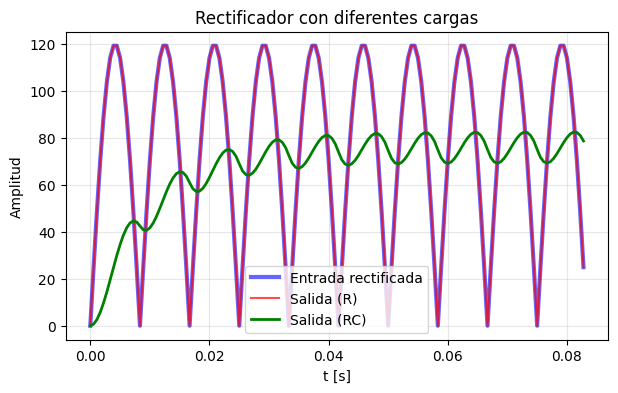

In [ ]:
# Gráfica rectificador con diferentes cargas

plt.figure(figsize=(7,4))
plt.plot(t, in_r, label='Entrada rectificada', color='blue', alpha=0.6, linewidth=3)
plt.plot(t, out_R, label='Salida (R)', color='red', alpha=0.7, linewidth=1.5)
plt.plot(t, out_RC, label='Salida (RC)', color='green', linewidth=2)
plt.xlabel('t [s]')
plt.ylabel('Amplitud')
plt.title('Rectificador con diferentes cargas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

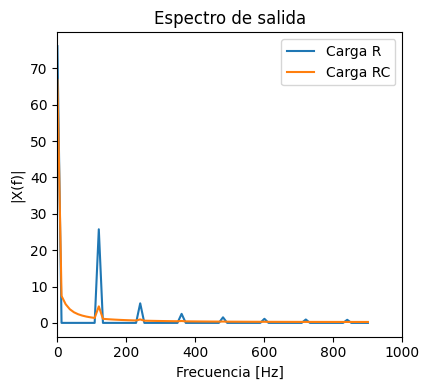

In [ ]:
# Gráfica espectro de salida

plt.figure(figsize=(8,4))
plt.subplot(1,2,2)
plt.plot(fR, specR, label='Carga R')
plt.plot(fRC, specRC, label='Carga RC')
plt.xlim(0, 1000)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|X(f)|')
plt.title('Espectro de salida')
plt.legend()
plt.tight_layout()
plt.show()

# Resultados

1. **Carga resistiva pura (R):** Cuando la carga del rectificador es puramente resistiva, la corriente y el voltaje están en fase. En este caso:

  * La señal de salida tiene la misma forma que la señal rectificada de entrada, con pulsos positivos que siguen directamente el semiciclo positivo de la entrada.
  * No hay almacenamiento de energía, por lo que el voltaje cae a cero entre cada pico.
  * El contenido armónico de la señal es elevado, ya que la onda rectificada se compone de muchos armónicos impares y pares que surgen de la no linealidad del rectificador.
  * Por ello, el THD (Total Harmonic Distortion) resulta alto, indicando una gran cantidad de distorsión respecto al fundamental.
  * Sin embargo, como no hay desfase entre voltaje y corriente, el factor de potencia (PF) sigue siendo alto (cercano a 1).

    **Conclusión:** La carga resistiva produce una señal con alta distorsión armónica, pero mantiene un buen factor de potencia al no introducir desfases.

2. **Carga RC (resistencia + capacitor):** Cuando se conecta un capacitor en paralelo con la resistencia, el comportamiento del circuito cambia considerablemente:

* El capacitor se carga durante los picos de la onda rectificada y se descarga lentamente entre ciclos, lo que genera una salida más suave o filtrada (menos ondulaciones o rizado).
* Esto significa que el THD disminuye, ya que el contenido de armónicos se reduce al tener una señal más continua.
* Sin embargo, el capacitor introduce un desfase entre el voltaje y la corriente (la corriente se adelanta al voltaje), afectando negativamente el factor de potencia.
* Por tanto, aunque el THD mejora, el PF disminuye debido al carácter reactivo del circuito.

**Conclusión:** La carga RC suaviza la forma de onda y reduce la distorsión armónica, pero introduce un desfase que reduce el factor de potencia total del sistema.


